# Import library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob


# Define transform to preprocess the data

In [2]:
transform = transforms.Compose([
    transforms.Resize((128,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Path to Dataset

In [3]:
train_path = "D:\\Datasets\\Anime_Sketch_Colorization_Pair\\train\\*.png"
test_path = "D:\\Datasets\\Anime_Sketch_Colorization_Pair\\test\\*.png"

train_glob = glob.glob(train_path)
test_glob = glob.glob(test_path)

print('Train Samples: ', len(train_glob))
print('Test Samples: ', len(test_glob))


Train Samples:  14224
Test Samples:  3545


# Custom Dataset

In [4]:
class ColorizationDataset(Dataset):
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
    def __getitem__(self, index):
        dataset_path = self.dataset_path[index]
        pil_img = Image.open(dataset_path)
        pil_img = transform(pil_img)
        return pil_img[:,:,pil_img.size(2) // 2:], pil_img[:,:,:pil_img.size(2) // 2]
    def __len__(self):
        return len(self.dataset_path)

# Load Dataset

In [5]:
train_dataset = ColorizationDataset(train_glob)
test_dataset = ColorizationDataset(test_glob)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

# Display sample

In [6]:
imgs_batch, masks_batch = next(iter(train_loader))

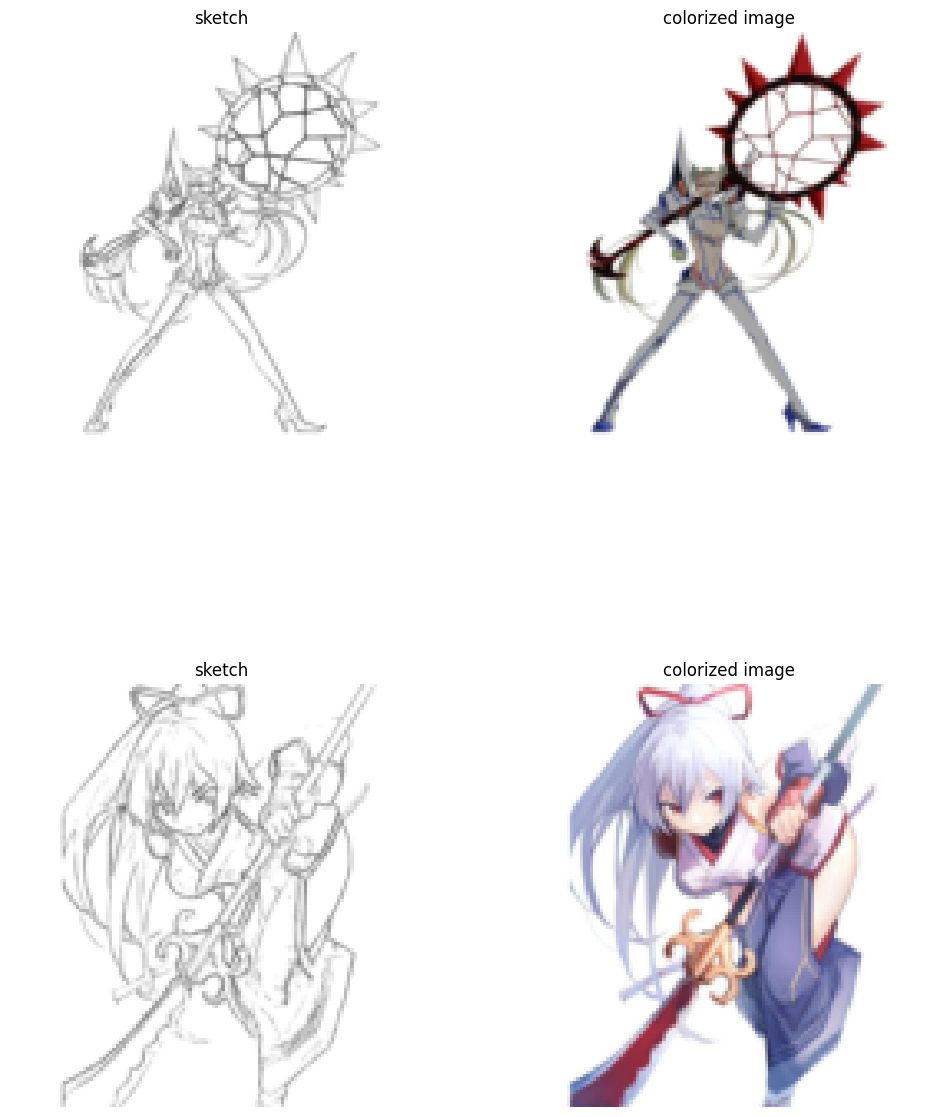

In [7]:
plt.figure(figsize=(12,24))
for i, (sketches, colors) in enumerate(zip(imgs_batch[:2], masks_batch[:2])):
    sketch = (sketches.permute(1,2,0).numpy()+1) / 2
    color = (colors.permute(1,2,0).numpy()+1) / 2
    plt.subplot(3,2,2*i+1)
    plt.title('sketch')
    plt.axis('off')
    plt.imshow(sketch)
    plt.subplot(3,2,2*i+2)
    plt.title('colorized image')
    plt.axis('off')
    plt.imshow(color)
plt.show()

# Define CNN Model

In [8]:
class ColorizationAutoencoder(nn.Module):
    def __init__(self):
        super(ColorizationAutoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Model instance and Training settings

In [9]:
model = ColorizationAutoencoder()

num_epochs = 20

optimizer = optim.Adam(model.parameters(), lr=6e-2, betas=(0.5, 0.999))

criterion = nn.MSELoss()


# Train the model

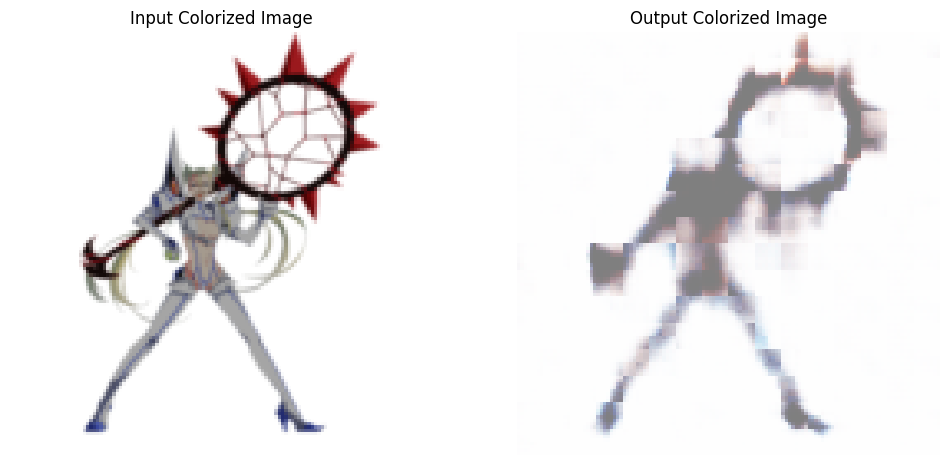

Epoch [1/20], Loss: 0.0671


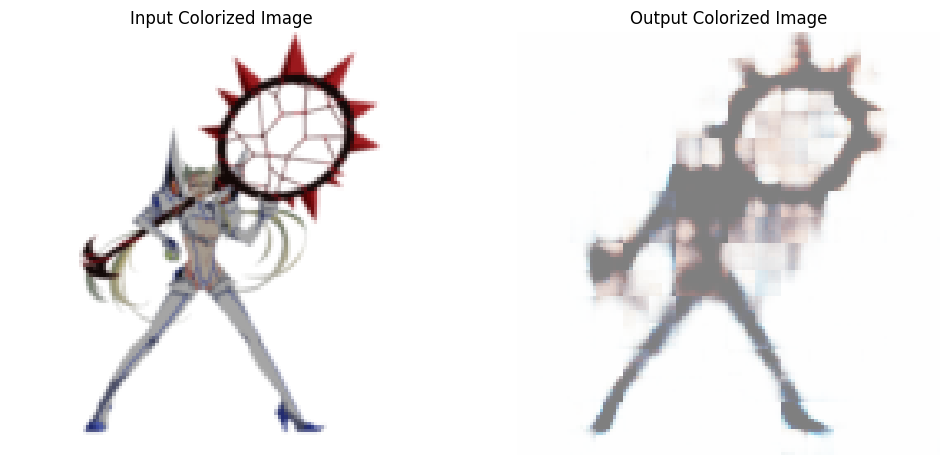

Epoch [2/20], Loss: 0.0509


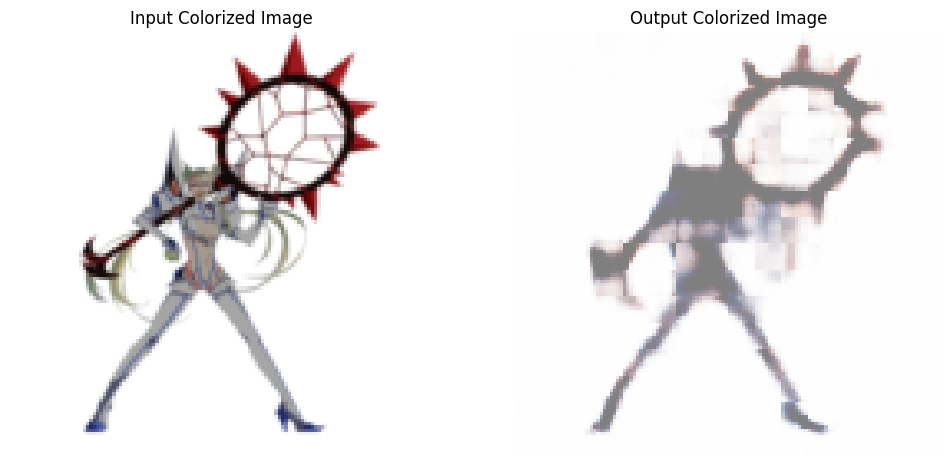

Epoch [3/20], Loss: 0.0474


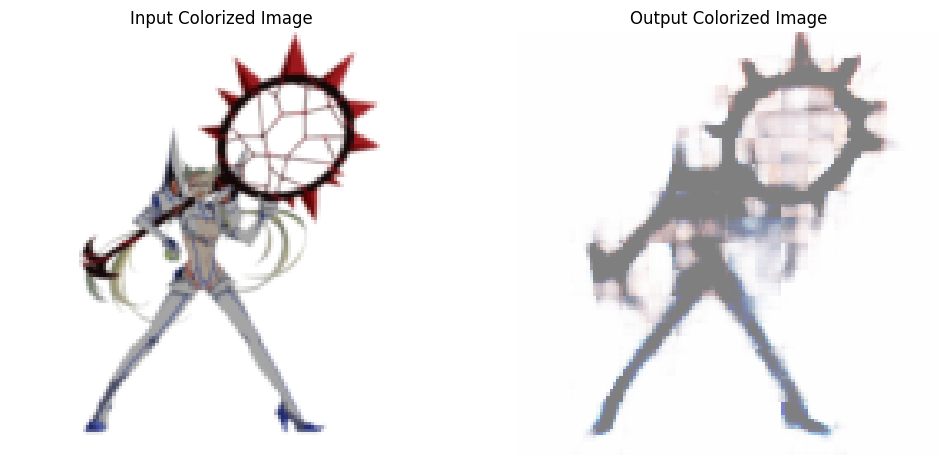

Epoch [4/20], Loss: 0.0453


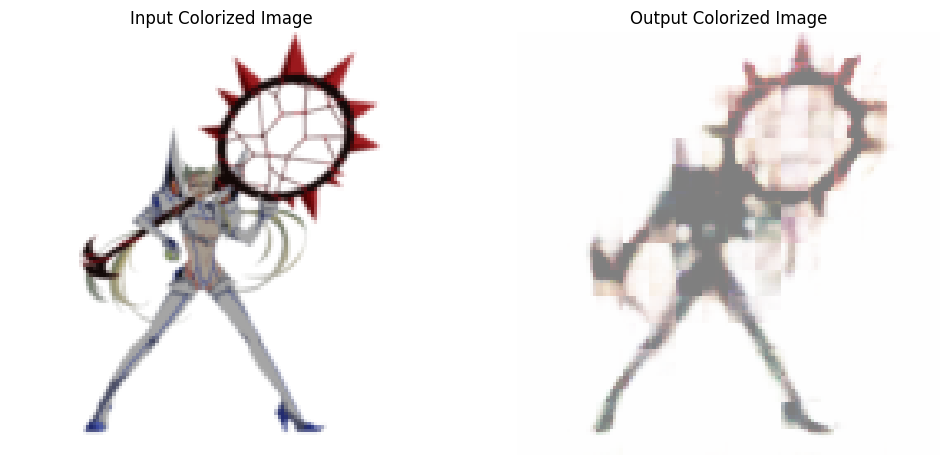

Epoch [5/20], Loss: 0.0440


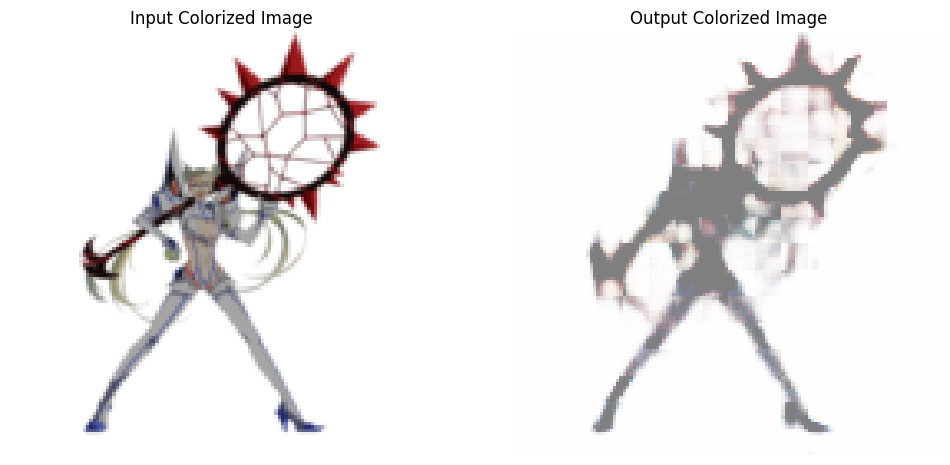

Epoch [6/20], Loss: 0.0429


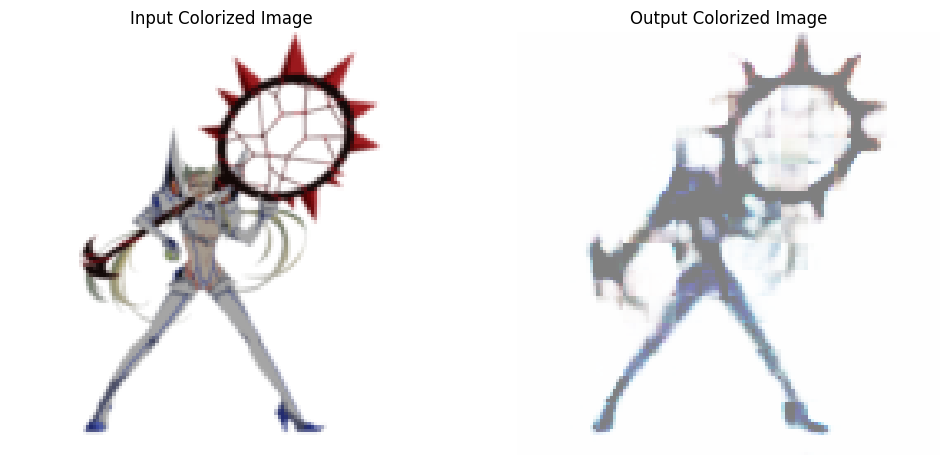

Epoch [7/20], Loss: 0.0420


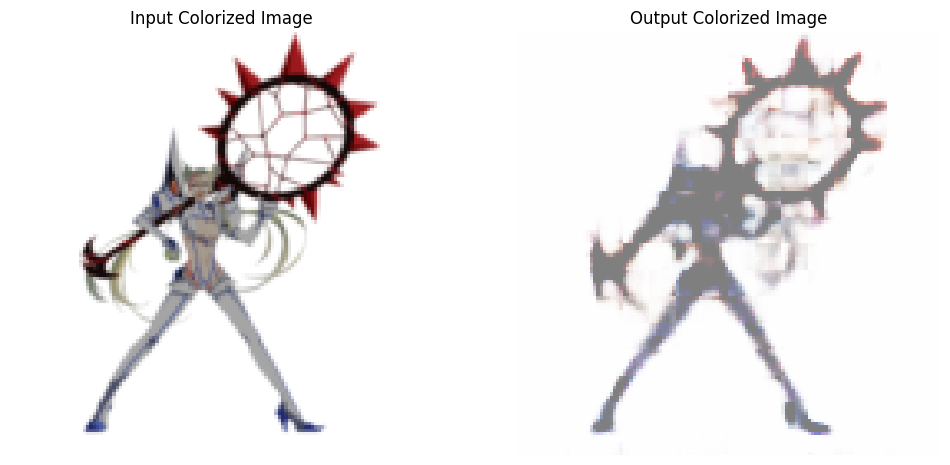

Epoch [8/20], Loss: 0.0413


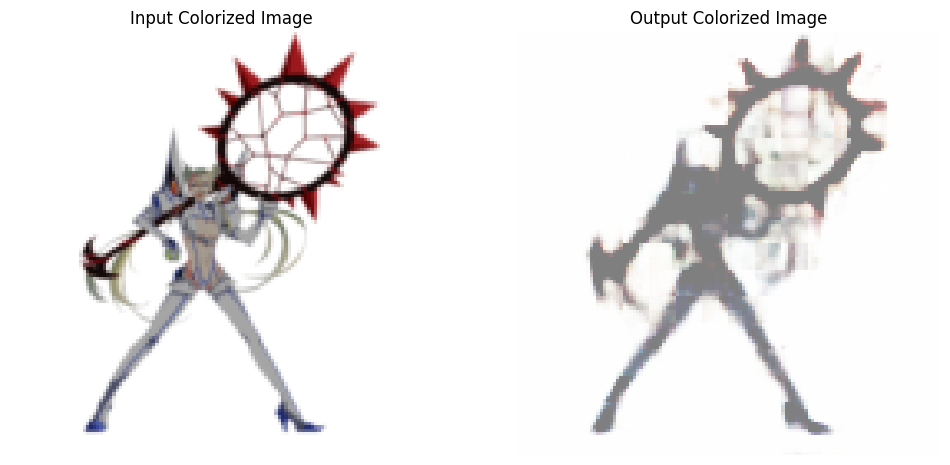

Epoch [9/20], Loss: 0.0408


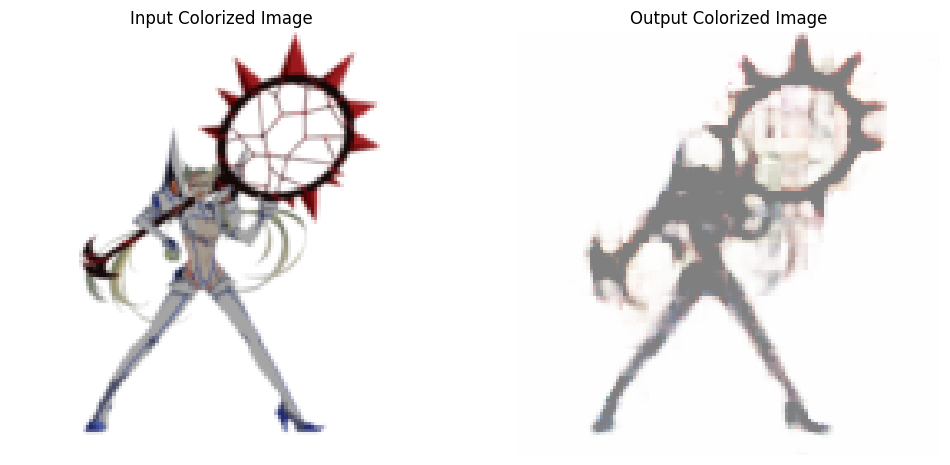

Epoch [10/20], Loss: 0.0405


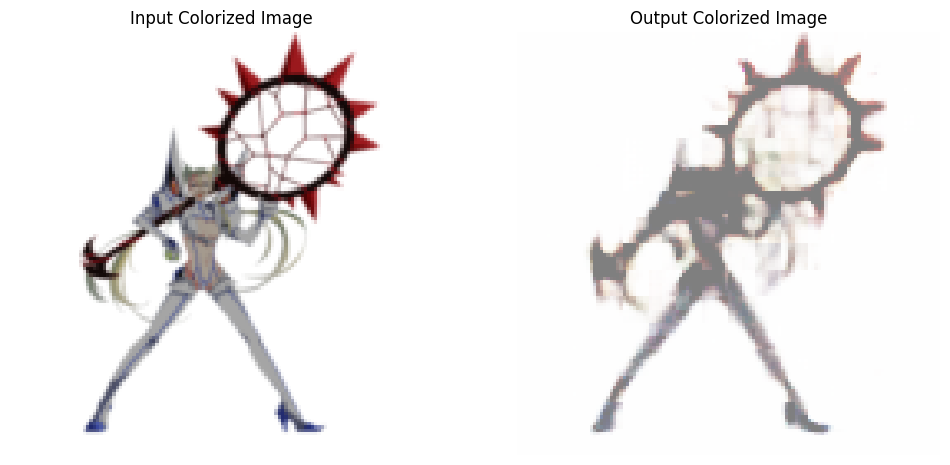

Epoch [11/20], Loss: 0.0399


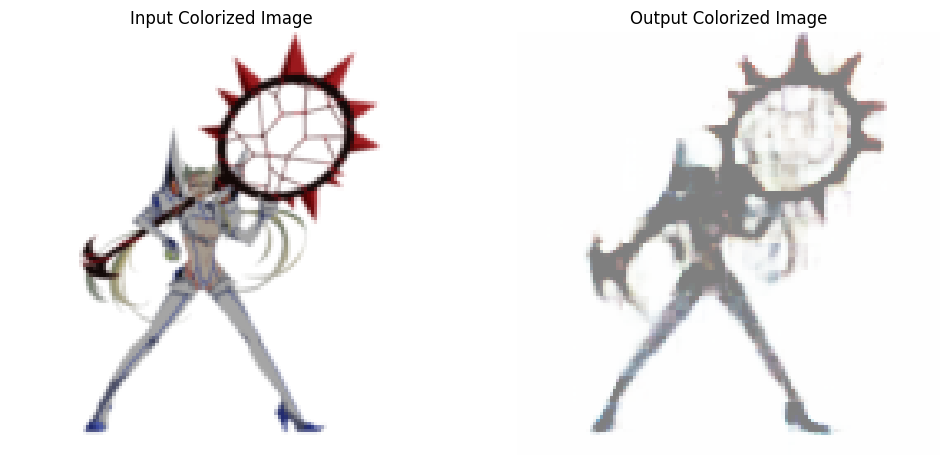

Epoch [12/20], Loss: 0.0395


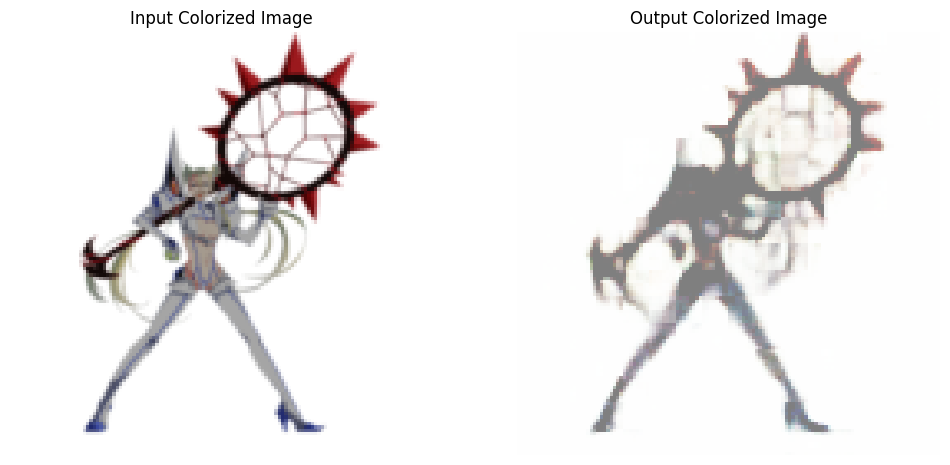

Epoch [13/20], Loss: 0.0392


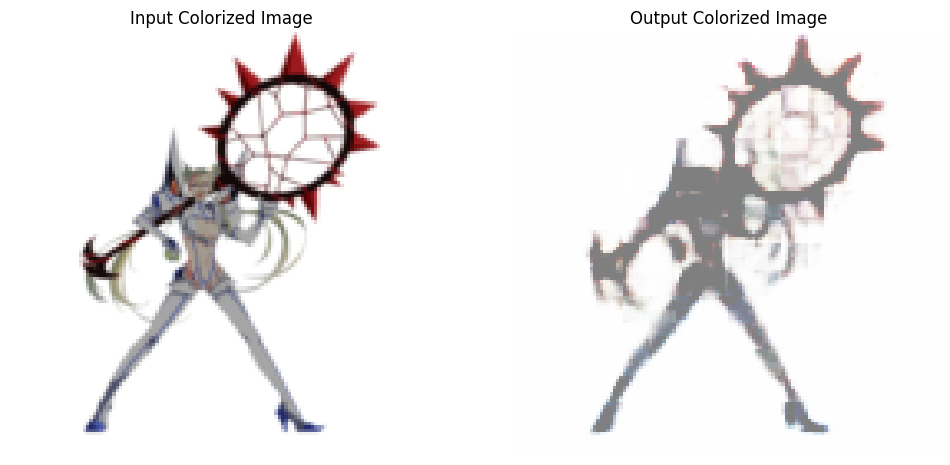

Epoch [14/20], Loss: 0.0390


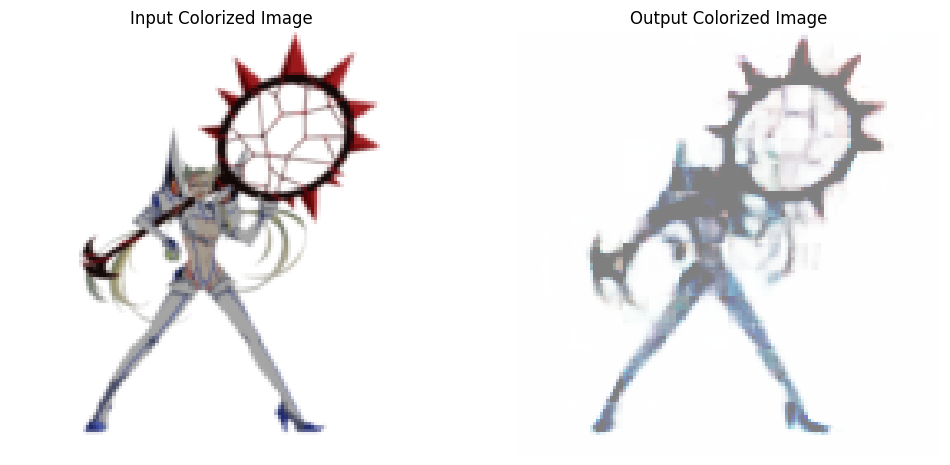

Epoch [15/20], Loss: 0.0387


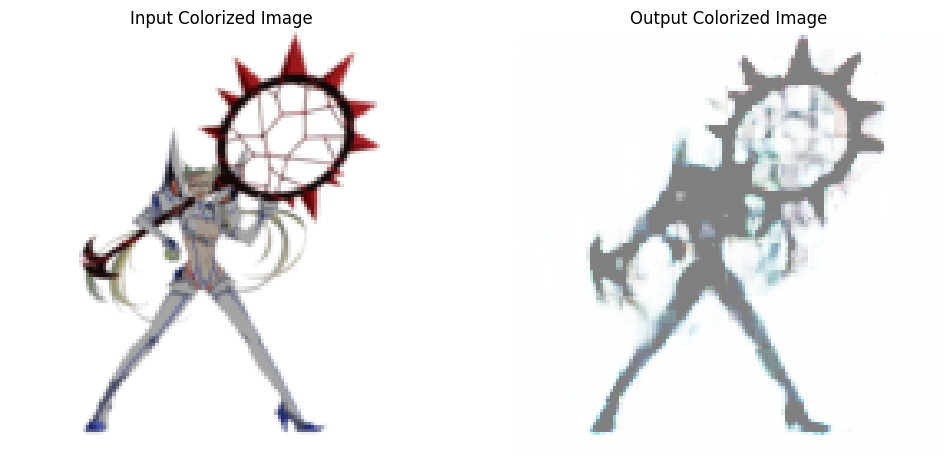

Epoch [16/20], Loss: 0.0384


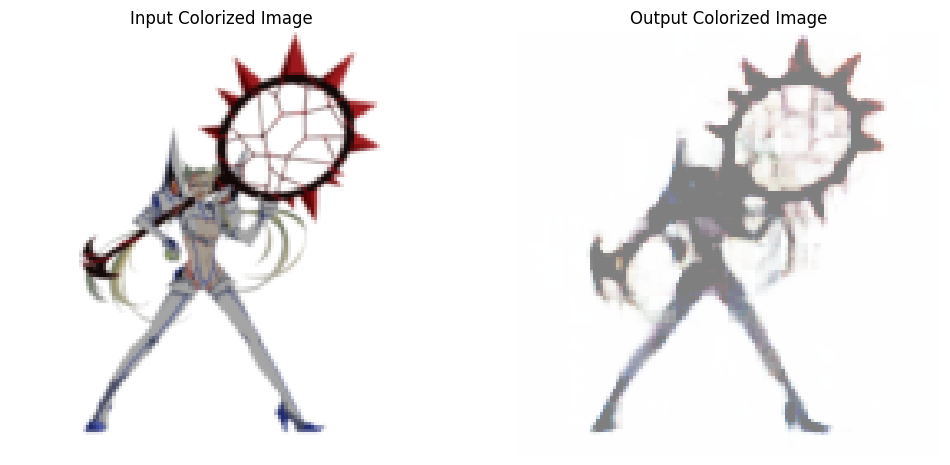

Epoch [17/20], Loss: 0.0383


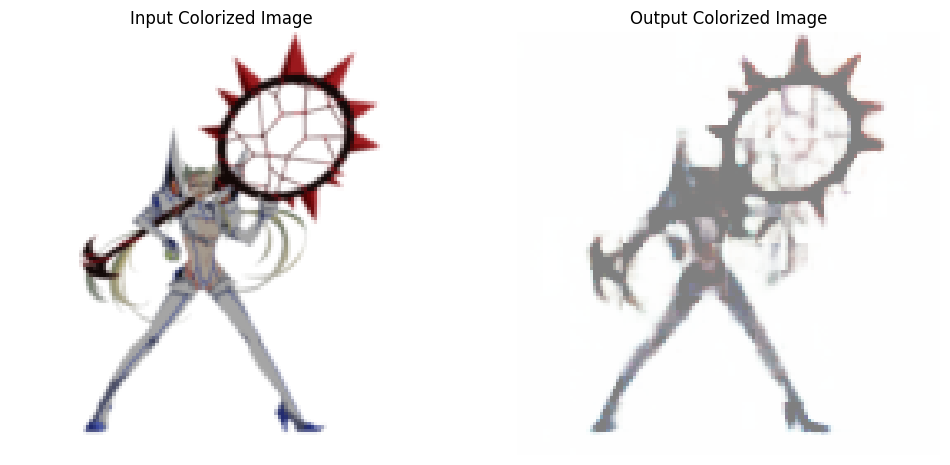

Epoch [18/20], Loss: 0.0380


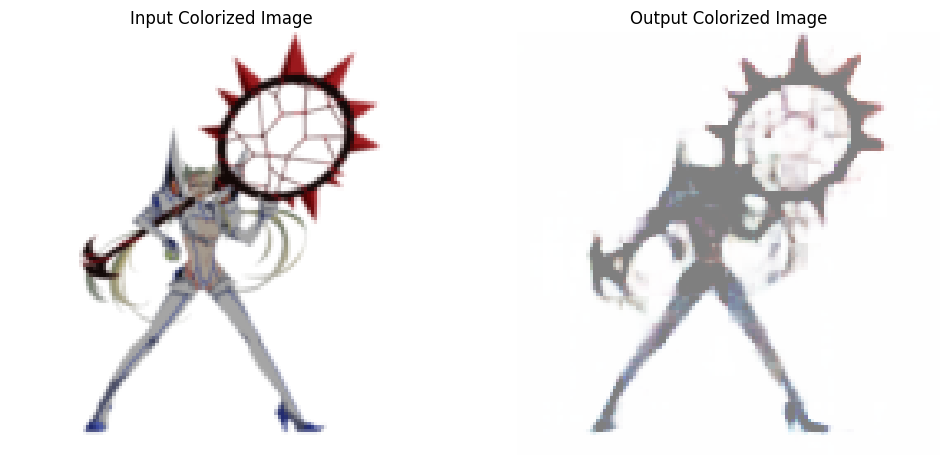

Epoch [19/20], Loss: 0.0378


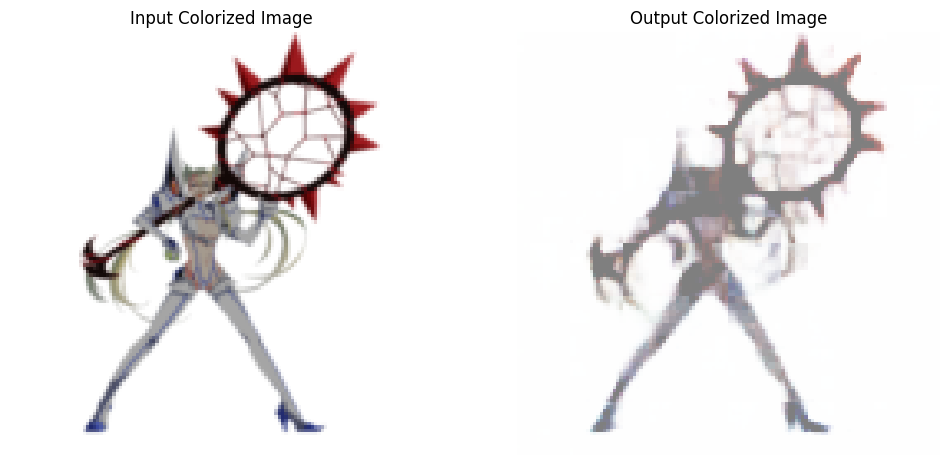

Epoch [20/20], Loss: 0.0377


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device)

loses_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (sketches, colors) in enumerate(train_loader):
#         sketches = sketches.to(device)
        colors = colors.to(device)
        
        outputs = model(colors)
        loss = criterion(outputs, colors)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    with torch.no_grad():
      sketches, colors = imgs_batch, masks_batch

      outputs = model(colors.to(device))
      plt.figure(figsize=(12,24))
#       sketch = (sketches[0].permute(1,2,0).cpu().numpy()+1) / 2
      color = (colors[0].permute(1,2,0).cpu().numpy()+1) / 2
      output = (outputs[0].permute(1,2,0).detach().cpu().numpy()+1) / 2
#       plt.subplot(1,2,1)
#       plt.title('Input Colorized Image')
#       plt.axis('off')
#       plt.imshow(sketch)
      plt.subplot(1,2,1)
      plt.title('Input Colorized Image')
      plt.axis('off') 
      plt.imshow(color)
      plt.subplot(1,2,2)
      plt.title('Output Colorized Image')
      plt.axis('off')
      plt.imshow(output)
      plt.show()

    loses_list.append(running_loss/len(train_loader))
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss/len(train_loader)))


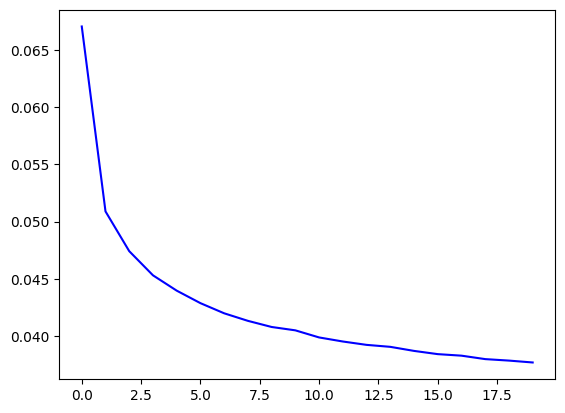

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from IPython.display import display
import numpy as np

plt.plot(range(epoch+1), loses_list, 'b')

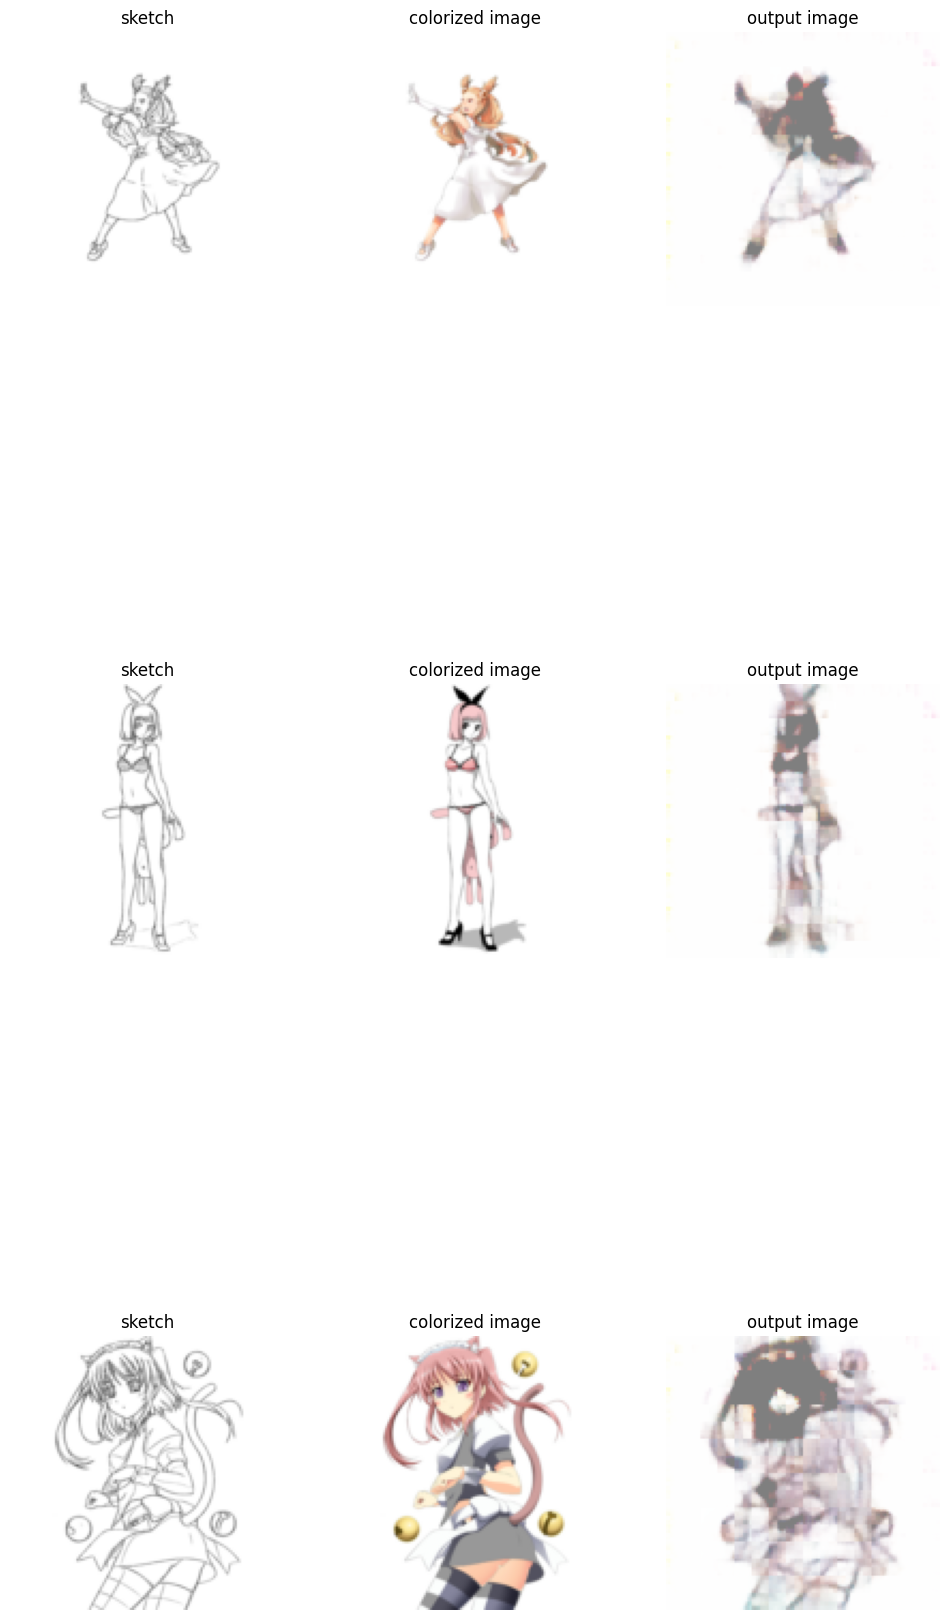

In [12]:
loss_avg = 0

y_true = []
y_pred = []

with torch.no_grad():
    running_loss = 0.0
    for batch_idx, (sketches, colors) in enumerate(test_loader):
        sketches = sketches.to(device)
        colors = colors.to(device)
        
        outputs = model(sketches)
        loss = criterion(outputs, colors)
        
        y_true.append(colors.to('cpu'))
        y_pred.append(outputs.to('cpu'))
        
        
        running_loss += loss.item()
    loss_avg = running_loss/len(test_loader)
    

    imgs_batch, masks_batch = next(iter(test_loader))
    outputs = model(imgs_batch.to(device))

    plt.figure(figsize=(12,24))
    for i, (sketches, colors) in enumerate(zip(imgs_batch[:3], masks_batch[0:3])):
        sketch = (sketches.permute(1,2,0).numpy()+1) / 2
        color = (colors.permute(1,2,0).numpy()+1) / 2
        output = (outputs[i].permute(1,2,0).detach().cpu().numpy()+1) / 2
        plt.subplot(3,3,3*i+1)
        plt.title('sketch')
        plt.axis('off')
        plt.imshow(sketch)
        plt.subplot(3,3,3*i+2)
        plt.title('colorized image')
        plt.axis('off')
        plt.imshow(color)
        plt.subplot(3,3,3*i+3)
        plt.title('output image')
        plt.axis('off')
        plt.imshow(output)
    plt.show()

In [15]:
loss_avg

0.1826782315254884